### Distribution function for the DM mini-halo

The idea is the construct an equilibrium distribution function for a DM mini-halo (around a PBH) with a density profile $\rho \sim r^{-3/2}$ within the truncation radius $r_\mathrm{tr}$. 

In [55]:
import numpy as np
import sympy as sp

from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad
from scipy.special import betainc, beta, btdtr,hyp2f1

from sympy.assumptions import assuming, Q

from __future__ import division

from matplotlib import pylab as pl
import matplotlib as mpl
mpl.rc('font', **{'size':18})

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1

def beta_incomplete(a,b,x):
    return (x**a/a)*hyp2f1(a,1-b,a+1,x)

**Parameters:**

Need to specify:
   - `MPBH` , the mass of PBH in solar masses
   - `a` , the semi-major axis of the orbit we're interested in, which determines the size of the DM halo

In [56]:
MPBH = 30
a = 0.01

#Load the values of a, r_tr, z from a file
avals, rvals, zvals = np.loadtxt("distributions/Decoupling_M=" + str(int(MPBH)) + "Msun.txt", unpack=True)
rtr_interp = interp1d(avals, rvals)

#Calculate the corresponding value of rtr
rtr = rtr_interp(a)
print "Truncation radius [pc]:", rtr
#print rtr_interp(0.0896960135445)

r_eq = 0.0063*(MPBH**(1.0/3.0)) #Truncation radius in pc at equality
G = 4.302e-3 #Units of (pc/solar mass) (km/s)^2
A = 3.0*MPBH/(8*np.pi*(rtr*r_eq)**1.5)


Truncation radius [pc]: 0.0043154407521


**DM Density profile:**

Note that the normalisation of the gNFW density profile `rho0` is fixed later on...

In [57]:
x_a = 1.0
rho0 = 1.0

def rho_inner(x):
    return 1.0/((x**(3/2))*(1 + x)**(6-3/2))    

alpha = 1.0*rho_inner(x_a)
#beta = (1.0/alpha)*1.0*3*(1+4*x_a)/(2*x_a**(5/2)*(1+x_a)**(11/2))
beta = 3*(1+4*x_a)/(2.0*x_a*(1+x_a))

def rho_outer(x):
    return alpha*sp.exp(-1.0*beta*(x-x_a))

def rho(x):
    if (x < x_a):
        return rho_inner(x)
    if (x >= x_a):
        return rho_outer(x)

def P(x):
    return 4*np.pi*1.0*x**(1/2)/((1 + x)**(4-3/2))

def rho_true(x):
    if (x > 1.0):
        return 0.0
    return A*x**(-1.5)

rho_vec = np.vectorize(rho)


**Calculate masses and potentials:**

In [19]:
x1,x2,x3,y = sp.symbols('x1 x2 x3 y')
rho0 = 1.0

def Menc_inner(x):
    return rtr**3*4*np.pi*1.0*2*(x**(3/2))*(35 + 28*x + 8*x**2)/(105.0*(1+x)**(7/2))

Mouter_fun = Menc_inner(x_a) + rtr**3*4*np.pi*sp.integrate(rho_outer(x1)*x1**2, (x1, x_a, x2))
#print Menc_inner(0.5)
#print Mouter_fun.subs(x1,1.5)
rho0 = ((rtr/r_eq)**1.5)*MPBH/Mouter_fun.subs(x2, 100)

def Menc(x):
    if (x < x_a):
        return MPBH + rho0*Menc_inner(x)
    elif (x >= x_a):
        return MPBH + rho0*Mouter_fun.subs(x2, x)    

def psi_outer(y):
    return (MPBH + rho0*Menc_inner(x_a))*G/(rtr*y) - (2**(-9/2))*4*np.pi*rtr**3*(G/rtr)*rho0*(np.exp((x_a - y)*beta)*alpha*(2 -2*np.exp(y*beta) + y*beta)/(y*beta**3))
    
def psi_inner1(y):
    num = 48-70*np.sqrt(y*(1+y)) - 112*np.sqrt(y**3*(1+y))+ \
            -48*np.sqrt(y**5*(1+y)) + 48*y*(3+y*(3+y))
    return (rtr**3*4*np.pi*rho0)*(G/rtr)*2*num/(105.0*(1+y)**3) + MPBH*G/(rtr*y)



def psi_inner(y):
    return psi_inner1(y) - psi_inner1(x_a) + psi_outer(x_a)

def psi(y):
    if (y < x_a):
        return psi_inner(y)
    elif (y >= x_a):
        return psi_outer(y)
    
psi_tr = float(psi(1.0))
psi_min = float(psi(100))
psi_max = float(psi(1e-6))



**Plot the density...**

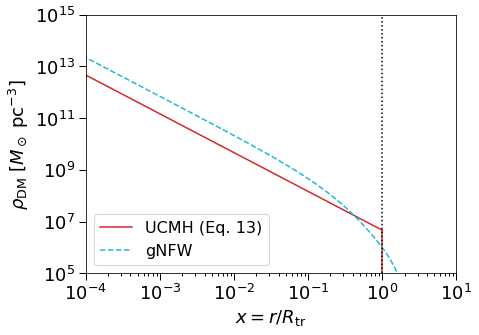

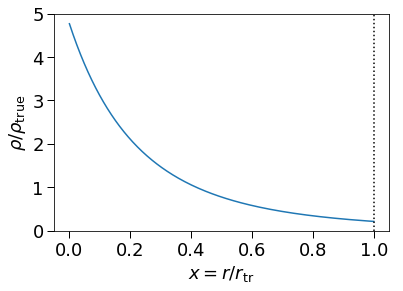

In [20]:
#Check the density
pl.figure(figsize=(7,5))
xlist = np.logspace(np.log10(1e-5), np.log10(10),1000)
pl.loglog(xlist, np.vectorize(rho_true)(xlist), label='UCMH (Eq. 13)', lw=1.5, color='C3')
pl.loglog([1.0, 1.0], [1e-3, rho_true(1.0)],lw=1.5, color='C3')
pl.loglog(xlist, rho0*np.vectorize(rho)(xlist),linestyle='--',label='gNFW', lw=1.5, color='C9')
#pl.loglog(xlist, rho_inner(xlist))
pl.xlabel(r"$x = r/R_\mathrm{tr}$")
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")
pl.ylim(1e5, 1e15)
pl.xlim(1e-4, 10)
pl.axvline(1.0, linestyle=':', color='k')
#pl.axvline(x_b, linestyle=':', color='k')
pl.legend(loc="best",fontsize=16.0)
#pl.xticks([1e-3, 1e-2, 1e-1, 1, 10], [r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$1$',r'$10$'])

pl.tight_layout()
pl.savefig("../plots/Halo_density.pdf",bbox_inches="tight")
pl.show()

#Check the density
pl.figure()
xlist = np.logspace(np.log10(1e-3), np.log10(10),1000)
pl.plot(xlist, rho0*np.vectorize(rho)(xlist)/np.vectorize(rho_true)(xlist),label='gNFW')
#pl.loglog(xlist, rho_inner(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\rho/\rho_\mathrm{true}$")
#pl.ylim(0, 1e6)
#pl.xlim(0.5, 5)
pl.axvline(1.0, linestyle=':', color='k')
#pl.axvline(x_b, linestyle=':', color='k')
#pl.legend(loc="best",fontsize=10.0)
#pl.tight_layout()
#pl.savefig("../../Halo_density.pdf",bbox_inches="tight" )
pl.show()

**Plot the potential and mass enclosed:**

Potential at x = 100: 0.326332124031
Potential at x = 1: 32.6284793218
Potential at x = 1e-5: 29906582.7363
 
Mass enclosed at x = 1: 2.66494774746521
Mass enclosed at x = 1.5: 2.97656222544752
Mass enclosed at x = 2: 3.07299927721676
Mass enclosed at x = 5: 3.10518320286526
Mass enclosed between at x = 5 and x = 8: 2.23501736229537e-6
 
Fraction of particles inside x = 1e-2: 0.00465973704321579


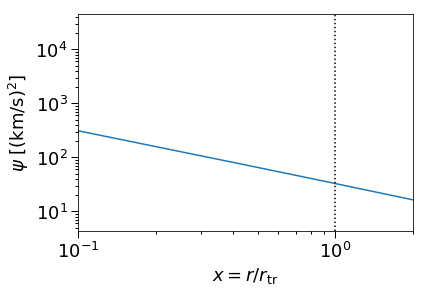

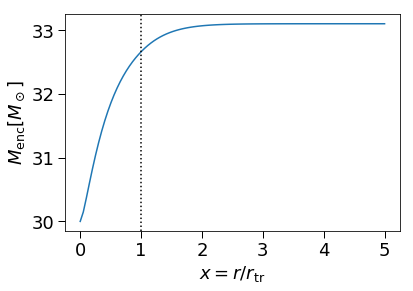

In [21]:
#Check the potential
print "Potential at x = 100:", psi_min
#print "Potential at x = 1.1:", psi_b
print "Potential at x = 1:", psi_tr
print "Potential at x = 1e-5:", psi_max
print " "
print "Mass enclosed at x = 1:", Menc(1.0)-MPBH
print "Mass enclosed at x = 1.5:", Menc(1.5)-MPBH
print "Mass enclosed at x = 2:", Menc(2)-30
print "Mass enclosed at x = 5:", Menc(5)-30
print "Mass enclosed between at x = 5 and x = 8:", Menc(8)-Menc(5)
print " "
print "Fraction of particles inside x = 1e-2:", (Menc(1e-2)-MPBH)/(Menc(100)-MPBH)

pl.figure()
xlist = np.linspace(1e-3, 5, 100)
pl.loglog(xlist, np.vectorize(psi)(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\psi$ [$(\mathrm{km}/\mathrm{s})^2$]")
#pl.axvline(x_a, linestyle=':', color='k')
pl.axvline(1.0, linestyle=':', color='k')
pl.xlim(0.1, 2)
pl.show()

pl.figure()
xlist = np.linspace(0.0, 5, 100)
pl.plot(xlist, np.vectorize(Menc)(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$M_\mathrm{enc} [M_\odot]$")
pl.axvline(1.0, linestyle=':', color='k')
#pl.axvline(x_b, linestyle=':', color='k')
pl.show()

**Calculating density as a function of potential:**

In [22]:
#List of x values
xlist = np.append(np.logspace(-5, 0, 2000),np.linspace(1.10001, 10.0, 1000))
xlist = np.append(xlist, np.linspace(10.1, 100.0, 1000))
xlist = np.append(xlist, np.linspace(0.9, 1.1, 1000))
xlist = np.sort(xlist)


In [23]:
rholist = np.vectorize(rho)(xlist)
psilist = np.asarray(np.vectorize(psi)(xlist),dtype='float64')
rholist = np.append(rholist, 0)
psilist = np.append(psilist, 0)
rho_of_psi = UnivariateSpline(psilist[::-1],rholist[::-1],k=5,s=0)

In [28]:
drho = rho_of_psi.derivative(n=1)
d2rho = rho_of_psi.derivative(n=2)

In [29]:
#c = 14.2844298406921
#def d2rho_fixed_scalar(p):
#    delta = 0.1
#    if (p < -1):
#        return 0.0
#    elif (psi_tr-delta < p <= psi_tr):
#        return d2rho(psi_tr - delta)
#    elif (psi_tr < p < psi_tr + delta):
#        return d2rho(psi_tr + delta)
#    elif (p >= -1):
#        return d2rho(p)

#d2rho_fixed = np.vectorize(d2rho_fixed_scalar)

**Calculating $f(\epsilon)$ over a grid of $\epsilon$ values**

In [34]:
def calcf1(eps):
    #if (eps <= psi_min):
    #    return 0.0
    if (eps < 1e-10):
        return 0.0
    integ = lambda p: rho0*d2rho(p)/np.sqrt(eps - p)
    return quad(integ, 0, eps)[0]/(np.sqrt(8)*np.pi**2)

In [35]:
e_list = np.append(np.logspace(np.log10(psi_min),np.log10(psi_tr-0.0001), 300),np.logspace(np.log10(psi_tr+0.0001), np.log10(psi_max),300))
e_list = np.sort(np.append(e_list, np.linspace(psi_tr-1.0, psi_tr+1.0, 100)))
e_list = np.append(0, e_list)


In [36]:
fvals = 0.0*e_list
for i in tqdm(range(len(e_list))):
    fvals[i] = calcf1(e_list[i])

#print fvals

 50%|█████     | 353/701 [00:17<00:17, 20.22it/s]/usr/local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
 98%|█████████▊| 690/701 [02:24<00:02,  4.77it/s]/usr/local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtai

In [37]:
#e_list, fvals = np.loadtxt("distribution_trunc3.dat", unpack=True)

In [38]:
finterp = UnivariateSpline(e_list, fvals, k=1,s=0)
def f(eps):
    #if (eps < 1):
    #    return 0.0
    return np.clip(finterp(eps),0,1e30)

f_vec = np.vectorize(f)

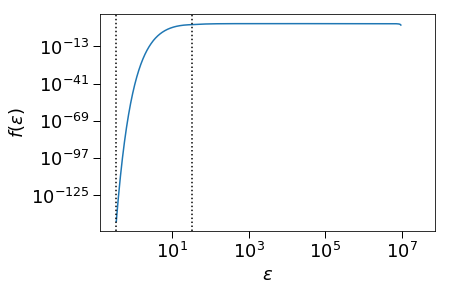

In [54]:
pl.figure()
pl.loglog(e_list,f_vec(e_list))
#pl.semilogx(e_list,np.vectorize(stepfun)(e_list))
#pl.axvline(psi_tr, linestyle=':', color='k')
#pl.ylim(1, 1e4)
#pl.xlim(0, 20.0)
#print psi(5)
pl.xlabel(r'$\epsilon$')
pl.ylabel(r'$f(\epsilon)$')
pl.axvline(psi_min, color='k', linestyle=":")
pl.axvline(psi_tr, color='k', linestyle=":")
pl.show()

**Re-checking the density:**

In [40]:
def vmax(x):
    return np.sqrt(2*float(psi(x)))

def dens(x):
    integ = lambda v: v**2*f(float(psi(x)) - 0.5*v**2)
    return 4*np.pi*quad(integ, 0, vmax(x))[0]

In [42]:
xlist2 = np.logspace(np.log10(1e-6), np.log10(10),50)
#xlist2 = np.linspace(0.85, 1.15,10)
dens_list = 0.0*xlist2
for i in tqdm(range(len(xlist2))):
    dens_list[i] = dens(xlist2[i])

100%|██████████| 50/50 [02:06<00:00,  2.52s/it]


19.1957135384004
70672.6380393279


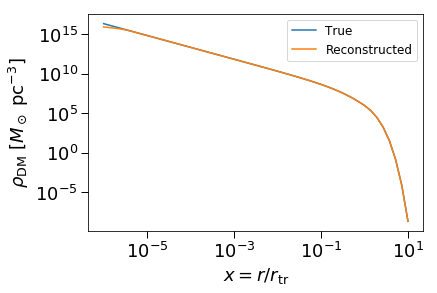

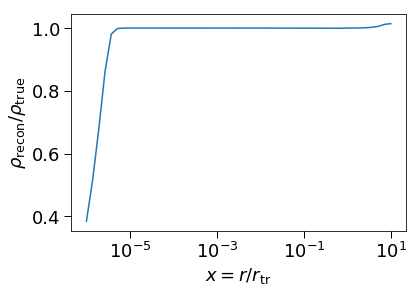

In [51]:
pl.figure()
pl.loglog(xlist2, rho0*np.vectorize(rho)(xlist2), label="True")
pl.loglog(xlist2, dens_list, label="Reconstructed")
pl.legend(loc='best',fontsize=12.0)
pl.xlabel(r'$x = r/r_\mathrm{tr}$')
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")

pl.figure()
pl.semilogx(xlist2, (1/rho0)*dens_list/np.vectorize(rho)(xlist2))
pl.xlabel(r'$x = r/r_\mathrm{tr}$')
pl.ylabel(r"$\rho_\mathrm{recon}/\rho_\mathrm{true}$")
#pl.ylim(0.99,1.01)
#pl.xlim(0, 2)
pl.show()

**Save the distribution function to file**

In [58]:
htxt = "M_PBH = " + str(int(MPBH)) + " M_solar, a/pc = "+"{0:.3f}".format(a) + ", r_tr/pc = " + str(rtr)
outfilename = "distributions/distribution_M=" + str(int(MPBH)) + "_a=" +"{0:.3f}".format(a) + ".dat"

np.savetxt(outfilename,zip(e_list,np.clip(fvals,0,1e30)), header=htxt)

print outfilename

distributions/distribution_M=30_a=0.010.dat


**Take a look at the distribution function**

In [45]:
#Speed distribution f(v) at a given radius r
def f_scalar(x, v):
    if (v >= vmax(x)):
        return 0.0
    else:
        return 4.0*np.pi*(v**2)*f(float(psi(x)) - 0.5*v**2)/(rho0*rho(x))

f_v = np.vectorize(f_scalar)

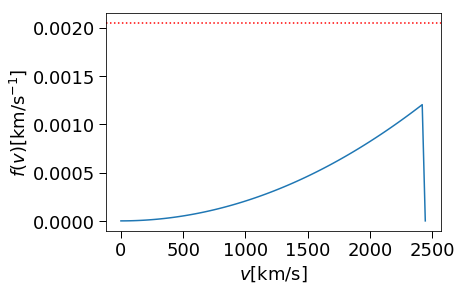

In [50]:
xpos = 1e-5
vlist = np.linspace(0, vmax(xpos),100)
#upper = 4*np.pi*vmax(xpos)**2*np.max(fvals[e_list < float(psi(xpos))])/rho(xpos)
#print upper
pl.figure()
pl.plot(vlist, f_v(xpos,vlist))
#pl.axhline(upper, linestyle=':', color='g')
pl.axhline(5.0/vmax(xpos), linestyle=':', color='r')
pl.xlabel(r'$v [\mathrm{km/s}]$')
pl.ylabel(r'$f(v) [\mathrm{km/s}^{-1}]$')
pl.show()


In [49]:
print "DONE!"

DONE!
